# Homework 3

### Due: Wed Nov. 15 @ 9pm

In this homework we will be performing model evaluation, model selection and feature selection in both a regression and classification setting.

The data we will be looking at are a subset of home sales data from King County, Washington, as we might see on a realestate website.


## Instructions

Follow the comments below and fill in the blanks (____) to complete.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

## Part 1: Regression

Here we try to build a model to predict adjusted sales price from a set of building features.

### Load and transform data

In [2]:
# Load data from file
infile_name = '../data/house_sales_subset.csv'
df = pd.read_csv(infile_name)

In [3]:
# Use a subset of the columns as features
X = df[['SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms','BldgGrade']]

In [4]:
# Extract the target, adjusted sale price
# Note: the '_r' here is denote the different targets for regression and classification
y_r = df.AdjSalePrice

In [5]:
# Split into 80% train and 20% test using train_test_split
from sklearn.model_selection import train_test_split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, test_size=.2)

### Measure baseline performance

In [6]:
# Train dummy model using DummyRegressor on the training set
from sklearn.dummy import DummyRegressor
dummy_r = DummyRegressor().fit(X_train_r,y_train_r)

In [7]:
# Calculate and print RMSE of the dummy model on the training set 
# hint: careful with the R!
from sklearn.metrics import mean_squared_error
dummy_r_training_rsme = np.sqrt(mean_squared_error(dummy_r.predict(X_train_r),y_train_r))
print('dummy RMSE: {:.3f}'.format(dummy_r_training_rsme))

dummy RMSE: 380683.087


In [8]:
# Calculate and print R2 of the dummy model on training set
# hint: can use models 'score' function
dummy_r_training_r2 = dummy_r.score(X_train_r,y_train_r)
print('dummy r2: {:.3f}'.format(dummy_r_training_r2))

dummy r2: 0.000


### Measure performance of Simple Linear Model

In [9]:
# Instantiate and train a simple LinearRegression model on the training set
from sklearn.linear_model import LinearRegression
lr_r = LinearRegression().fit(X_train_r,y_train_r)

In [10]:
# Calculate RMSE of simple linear model on training set
# Note the improvement over the dummy model
from sklearn.metrics import mean_squared_error
lr_r_rmse = np.sqrt(mean_squared_error(lr_r.predict(X_train_r),y_train_r))
print('simple linear RMSE: {:.3f}'.format(lr_r_rmse))

simple linear RMSE: 258038.764


In [11]:
# Calculate R2 of the simple linear model on training set
# Note the improvement over the dummy model
lr_r_r2 = lr_r.score(X_train_r,y_train_r)
print('simple linear r2: {:.3f}'.format(lr_r_r2))

simple linear r2: 0.541


In [12]:
# Calculate mean 5-fold Cross Validation R2 score of simple linear model on the training set using cross_val_score
# Note any difference from the R2 score on the full training set (there shouldn't be a large one)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LinearRegression(), X_train_r, y_train_r, cv=5)
print('simple linear mean cv r2: {:.3f}'.format(np.mean(scores)))

simple linear mean cv r2: 0.541


### Model selection

In [13]:
# Create a pipeline using make_pipeline to generate polynomial models
# There should be two steps: PolynomalFeatures then LinearRegression
# Recall: using PolynomialFeatures, we do not need to fit an intercept in the LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
poly_pipeline = make_pipeline(PolynomialFeatures(),LinearRegression(fit_intercept=False))

In [14]:
# Perform GridSearch over different polynomial degrees = [1,2,3,4] using the training set
# To do this, instantiate and fit GridSearchCV on our poly_pipeline model and params set 
# hint: "polynomialfeatures__degree" is the parameter of interest
from sklearn.model_selection import GridSearchCV
params = {'polynomialfeatures__degree':[1,2,3,4]}
gs = GridSearchCV(poly_pipeline, params).fit(X_train_r, y_train_r)

In [15]:
# Print out the best score found and the best parameter setting found
print('gs best score : {:.3f}'.format(gs.best_score_))
print('gs best params: {}'.format(gs.best_params_))

gs best score : 0.604
gs best params: {'polynomialfeatures__degree': 2}


In [16]:
# Retrain poly_pipeline using the best parameter setting found above on the entire training set
# Print the RMSE and R2 of the new model on the training set
# hint: polynomialfeatures__degree is the parameter you need to set
poly_pipeline.set_params(polynomialfeatures__degree=2).fit(X_train_r,y_train_r)
poly_train_rmse = np.sqrt(mean_squared_error(poly_pipeline.predict(X_train_r),y_train_r))
poly_train_r2 = poly_pipeline.score(X_train_r,y_train_r)
print('polynomial training RMSE: {:.3f}'.format(poly_train_rmse))
print('polynomial training R2  : {:.3f}'.format(poly_train_r2))

polynomial training RMSE: 234685.975
polynomial training R2  : 0.620


In [17]:
# Using the newly trained model, get predictions on the full training set
y_hat = poly_pipeline.predict(X_train_r)

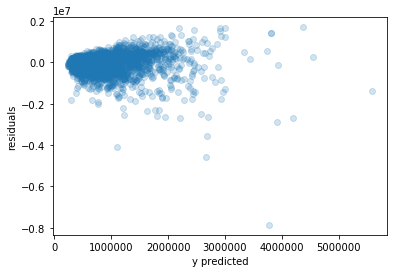

In [18]:
# Plot predictions (x-axis) vs residuals (y-axis)
# recall: residual = y_hat - y
residuals = y_hat - y_train_r
_ = plt.scatter(y_hat, residuals, alpha=0.2)
_ = plt.xlabel('y predicted')
_ = plt.ylabel('residuals')
# if this were a real analysis, we may want to address any of the outliers we see here
# also you should be seeing some signs of heteroskedasticity here

### Evaluate trained model on Test

In [19]:
# Using our trained model, calculate R2 and RMSE on the test set
# Note that error may have gone up slightly and r2 may have decreased slightly
print('test RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(poly_pipeline.predict(X_test_r),y_test_r))))
print('test r2  : {:.3f}'.format(poly_pipeline.score(X_test_r,y_test_r)))

test RMSE: 243390.071
test r2  : 0.637


### Feature selection

In [20]:
# Select the top 2 most informative features from the trained model using SelectKBest and f_regression
# To do this, instantiate and fit SelectKbest on the training set
from sklearn.feature_selection import SelectKBest, f_regression
skb = SelectKBest(f_regression, k=2).fit(X_train_r, y_train_r)

In [21]:
# Print out the selected features using skb.get_support() and the column names from X_train_r
kept_columns = X_train_r.columns[skb.get_support()]
print('kept columns: {}'.format(kept_columns))

kept columns: Index(['SqFtTotLiving', 'BldgGrade'], dtype='object')


---

## Part 2: Classification

Here we try to build a model to predict low vs. high adjusted sales price.

## Create classification target

In [22]:
# Here we create a binary target by thresholding at the AdjSalePriceMedian
y_c = (df.AdjSalePrice > df.AdjSalePrice.median()).astype(int)
print('proportion of low to high: {:.3f}'.format(sum(y_c)/float(len(y_c))))

proportion of low to high: 0.500


In [23]:
# Split into 80% train and 20% test using train_test_split
# Use our new y_c target and the same X we used for regression
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_c, test_size=0.2)

### Measure baseline performance

In [24]:
# Train a dummy classification model on the training set
from sklearn.dummy import DummyClassifier
dummy_c = DummyClassifier().fit(X_train_c, y_train_c)

In [25]:
# Calculate Training set Accuracy of the dummy classifier
# This should match the proportion of low to high
dummy_c_acc = dummy_c.score(X_train_c, y_train_c)
print('dummy accuracy: {:.3f}'.format(dummy_c_acc))

dummy accuracy: 0.499


### Measure performance of a Random Forest model

In [26]:
# Calculate training set accuracy of a random forest with 5 trees
# Note: why is this so high?
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5).fit(X_train_c,y_train_c)
print('rf accuracy: {:.3f}'.format(rf.score(X_train_c,y_train_c)))

rf accuracy: 0.967


In [27]:
# Calculate mean 5-fold cross validation accuracy of a random forest with 5 trees on the training set
# Note that it should be less than the accuracy when trained on the full training set
from sklearn.model_selection import StratifiedKFold
scores = cross_val_score(RandomForestClassifier(n_estimators=5), X_train_c, y_train_c, cv=5)
print('mean cv accuracy: {:.3f}'.format(np.mean(scores)))

mean cv accuracy: 0.784


### Model selection

In [28]:
# Perform cross validated grid search over the number of trees in [1,5,10] using the training set
params = {'n_estimators':[1,5,10]}
gs = GridSearchCV(RandomForestClassifier(),params).fit(X_train_c,y_train_c)

In [29]:
# Print out the best score found and the best parameter setting found
print('gs best accuracy: {:.3f}'.format(gs.best_score_))
print('gs best params  : {}'.format(gs.best_params_))

gs best accuracy: 0.789
gs best params  : {'n_estimators': 10}


In [30]:
# Retrain on the entire training set using the best number of trees found
rf = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators']).fit(X_train_c,y_train_c)

In [31]:
# get p(y=1|x) for the entire training set
# hint: py_pos should only contain one column
py_pos = rf.predict_proba(X_train_c)[:,1]

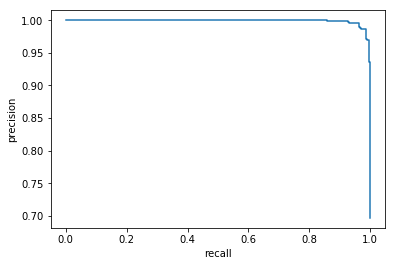

In [32]:
# Plot Precision (y-axis) vs. Recall (x-axis) using the targets and py_pos 
# The plot should indicate a good fit at almost any classification threshold
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_train_c, py_pos)
_ = plt.step(recall,precision)
_ = plt.xlabel('recall')
_ = plt.ylabel('precision')

### Evaluate model performance on the Test set

In [33]:
# Calculate accuracy of the trained model on the test set
# Note that it should not be far from the cv training set accuracy
print('test accuracy: {:.3f}'.format(rf.score(X_test_c,y_test_c)))

test accuracy: 0.789


### Feature selection

In [34]:
# Select the most informative features using SelectFromModel using 'mean' as threshold
# note: this may select more than 2 features
# note: we use prefit=True since the model is already trained
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf, threshold='mean', prefit=True)

In [35]:
# print out the selected features using get_support() and columns from X 
kept_columns = X.columns[sfm.get_support()].tolist()
print('kept columns: {}'.format(kept_columns))

kept columns: ['SqFtTotLiving', 'SqFtLot', 'BldgGrade']


In [36]:
# transform X_train_c into a new X containing only the selected features
X_train_c_fs = sfm.transform(X_train_c)

In [37]:
# Train a new model on the new X using the previously found best setting for n_estimators
rf_fs = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators']).fit(X_train_c_fs,y_train_c)

In [38]:
# Predict P(y=1|x) using the new model
py_pos_fs = rf_fs.predict_proba(X_train_c_fs)[:,1]

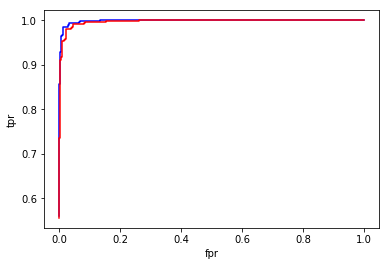

In [39]:
# Plot the ROC curves of the old model and the new model on the same plot
# Note that the full model is only a slight improvement on the model with fewer features
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_train_c, py_pos)
fpr_fs,tpr_fs,_ = roc_curve(y_train_c, py_pos_fs)
_ = plt.step(fpr,tpr,color='blue')
_ = plt.step(fpr_fs,tpr_fs,color='red')
_ = plt.xlabel('fpr')
_ = plt.ylabel('tpr')

In [40]:
# Confirm that the new and old models are similar by calculating their ROC AUC values on the training set
# hint: use the py_pos you predicted for both models
from sklearn.metrics import roc_auc_score
full_model_auc = roc_auc_score(y_train_c,py_pos)
fs_model_auc = roc_auc_score(y_train_c,py_pos_fs)
print('full model auc: {:.3f}'.format(full_model_auc))
print('fs model auc  : {:.3f}'.format(fs_model_auc))

full model auc: 0.998
fs model auc  : 0.997
